In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load and prepare Titanic data
titanic_train = pd.read_csv("train.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_train["Age"])     # Value if check is false

titanic_train["Age"] = new_age_var 

In [3]:
from sklearn import tree
from sklearn import preprocessing

In [4]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Initialize model
tree_model = tree.DecisionTreeClassifier()

# Train the model
tree_model.fit(X = pd.DataFrame(encoded_sex), 
               y = titanic_train["Survived"])

DecisionTreeClassifier()

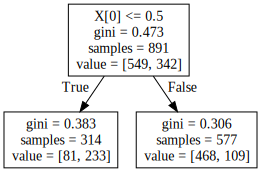

In [5]:
import graphviz

# Save tree as dot file
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 
#Суть - если соблюдается условие x[0] <= 0.5, то 314 человек из выборки подразделяются на одну подруппу, а если нет, то на другую и таких 577. 
#В данном случае речь идёт о разделении на женщин и мужчин

In [6]:
# Get survival probability
preds = tree_model.predict_proba(X = pd.DataFrame(encoded_sex))
female = preds[titanic_train["Sex"] == "female"][0][1]
male = preds[titanic_train["Sex"] == "male"][0][1]

print(female)
print(male)
#Вероятность выжить для женщины - 74,2%, а для мужчины только 18,9%

0.7420382165605095
0.18890814558058924


In [7]:
# Make data frame of predictors
predictors = pd.DataFrame([encoded_sex, titanic_train["Pclass"]]).T

# Train the model
tree_model.fit(X = predictors, 
               y = titanic_train["Survived"])

DecisionTreeClassifier()

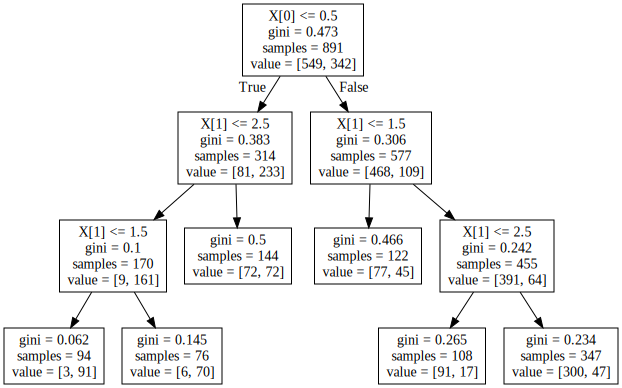

In [8]:
import graphviz

# Save tree as dot file
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 

In [9]:
# Get survival probability
preds = tree_model.predict_proba(X = predictors)

# Create a table of predictions by sex and class
pd.crosstab(preds[:,0], columns = [titanic_train["Pclass"], 
                                   titanic_train["Sex"]])
#Здесь мы видим, что смертность различается в зависимости от класса. В 3 классе самый высокий уровень смертности.

Pclass        1           2           3     
Sex      female male female male female male
row_0                                       
0.031915     94    0      0    0      0    0
0.078947      0    0     76    0      0    0
0.500000      0    0      0    0    144    0
0.631148      0  122      0    0      0    0
0.842593      0    0      0  108      0    0
0.864553      0    0      0    0      0  347

In [10]:
predictors = pd.DataFrame([encoded_sex,
                           titanic_train["Pclass"],
                           titanic_train["Age"],
                           titanic_train["Fare"]]).T

# Initialize model with maximum tree depth set to 8
tree_model = tree.DecisionTreeClassifier(max_depth = 8)

tree_model.fit(X = predictors, 
               y = titanic_train["Survived"])

DecisionTreeClassifier(max_depth=8)

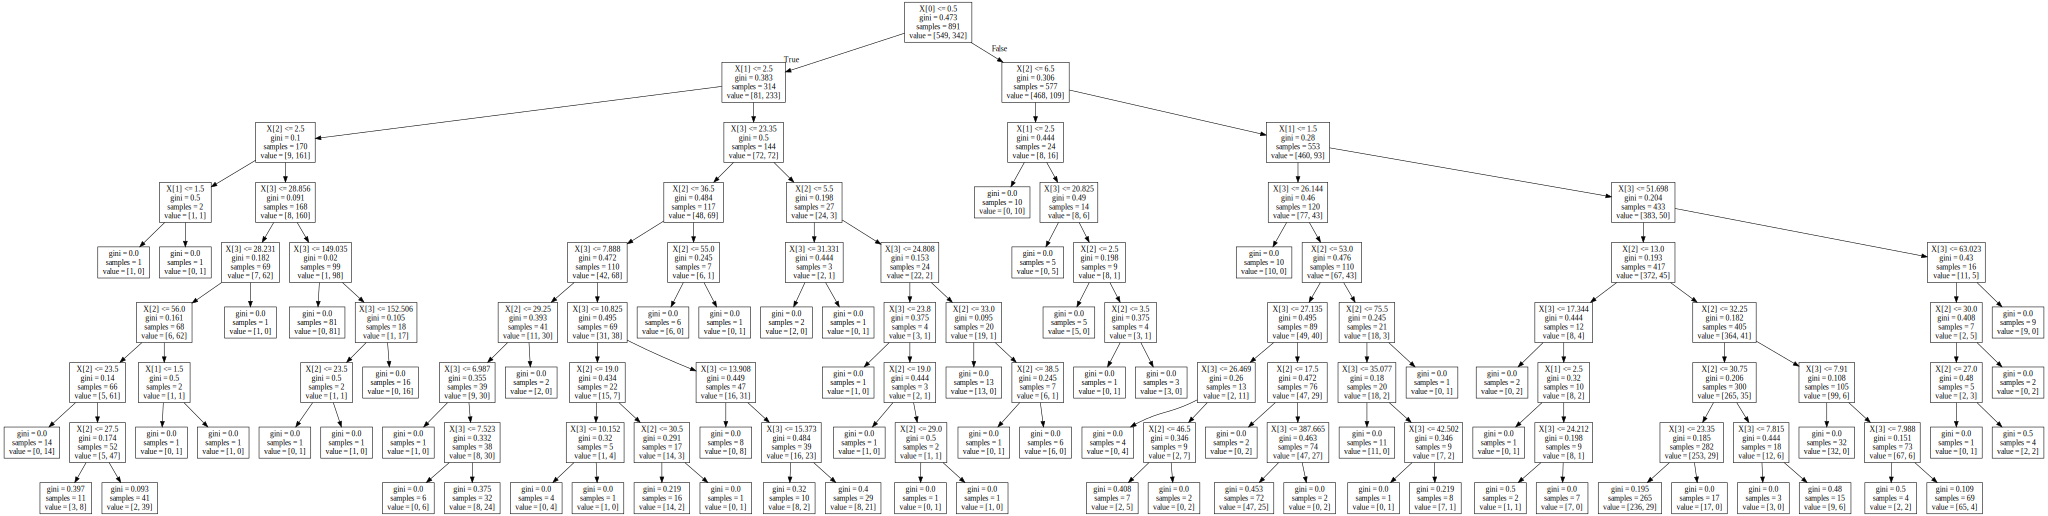

In [11]:
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 

In [12]:
tree_model.score(X = predictors, 
                 y = titanic_train["Survived"])
#Модель на 89% точна

0.8911335578002245

In [15]:
# Read and prepare test data
titanic_test = pd.read_csv("test.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_test["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_test["Age"])      # Value if check is false

new_fare_var = np.where(titanic_test["Fare"].isnull(), # Logical check
                       50,                       # Value if check is true
                       titanic_test["Fare"])      # Value if check is false

titanic_test["Age"] = new_age_var 
titanic_test["Fare"] = new_fare_var

In [16]:
# Convert test variables to match model features
encoded_sex_test = label_encoder.fit_transform(titanic_test["Sex"])

test_features = pd.DataFrame([encoded_sex_test,
                              titanic_test["Pclass"],
                              titanic_test["Age"],
                              titanic_test["Fare"]]).T

In [17]:
# Make test set predictions
test_preds = tree_model.predict(X=test_features)

# Create a submission for Kaggle
submission = pd.DataFrame({"PassengerId":titanic_test["PassengerId"],
                           "Survived":test_preds})

# Save submission to CSV
submission.to_csv("tutorial_dectree_submission.csv", 
                  index=False)        # Do not save index values

In [18]:
#Holdout validation
from sklearn.model_selection import train_test_split
#А затем выделяем по кусочку из данных - тренировочный сет и валидационный сет

In [19]:
v_train, v_test = train_test_split(titanic_train,     # Data set to split
                                   test_size = 0.25,  # Split ratio
                                   random_state=1,    # Set random seed
                                   stratify = titanic_train["Survived"]) #*

# Training set size for validation
print(v_train.shape)
# Test set size for validation
print(v_test.shape)

(668, 12)
(223, 12)


The output above shows that we successfully created a new training set with roughly 75% of the original data and a validation test set with 25% of the data. We could proceed by building models with this new training set and making predictions on the validation set to assess the models.

In [21]:
#Но есть ещё кросс-валидация, которая предполагает разбитие тестового датасета на несколько партиций.
#Для этого применяем KFold
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=12, shuffle=True)
kf.get_n_splits(titanic_train)

10

In [22]:
fold_accuracy = []

titanic_train["Sex"] = encoded_sex

for train_fold, valid_fold in kf.split(titanic_train):
    train = titanic_train.loc[train_fold] # Extract train data with cv indices
    valid = titanic_train.loc[valid_fold] # Extract valid data with cv indices
    
    model = tree_model.fit(X = train[["Sex","Pclass","Age","Fare"]], 
                           y = train["Survived"])
    valid_acc = model.score(X = valid[["Sex","Pclass","Age","Fare"]], 
                            y = valid["Survived"])
    fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", fold_accuracy, "\n")
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Accuracy per fold:  [0.8333333333333334, 0.7415730337078652, 0.8426966292134831, 0.7640449438202247, 0.797752808988764, 0.9325842696629213, 0.8202247191011236, 0.8314606741573034, 0.8539325842696629, 0.8314606741573034] 

Average accuracy:  0.8249063670411987


In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
scores = cross_val_score(estimator= tree_model,     # Model to test
                X= titanic_train[["Sex","Pclass",   # Train Data
                                  "Age","Fare"]],  
                y = titanic_train["Survived"],      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print(scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
[0.74444444 0.83146067 0.75280899 0.85393258 0.87640449 0.79775281
 0.83146067 0.76404494 0.85393258 0.84269663]
Average accuracy:  0.8148938826466916
